### Much of the repetitive code in this notebook was written by ChatGPT, including the following summary

## Summary of the Process for Hurricane harvey Data Analysis
(same thing for Dorian)

### Step 1: Load the Dataset
- Action: Load the `harvey` dataset using `pandas.read_csv()`, skipping unnecessary rows.
- Time Intervals: `201703`, `20190830`.

### Step 2: Rename Columns
- Rename columns to reflect the time intervals and land types (dense vegetation, sparse vegetation, sand, water).

### Step 3: Calculate Total Areas for Each Time Interval
- For each time interval, sum the columns related to the four land types (dense vegetation, sparse vegetation, sand, water) to get the total area.

### Step 4: Calculate Fractional Areas
- Divide the area of each land type by the total area for each time interval to calculate the fractional areas for each land type.

### Step 5: Calculate Actual Vegetation Areas
- Multiply the `area_m2` by the fractional values for dense and sparse vegetation to get the actual areas for both time intervals.

### Step 6: Sum the Total Vegetation Areas
- Sum the dense and sparse vegetation areas for each time interval to get the total vegetation area.

### Step 7: Create a DataFrame for Summarized Data
- Create a new DataFrame `veg_area_df_harvey` to store the total vegetation area for both time intervals.

### Step 8: Plot the Total Vegetation Area Over Time
- Plot the total vegetation areas over the two time intervals (`201703`, `20190830`).

### Step 9: Save the DataFrame to a CSV File
- Save the summarized DataFrame (`veg_area_df_harvey`) as a CSV file: `harvey_vegetation_area_sums.csv`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
dorian = pd.read_csv('Supplemental_Table_Dorian.csv', skiprows=3, header=None )
# Drop columns 6, 11, and 16 (remember, pandas uses 0-based indexing, so columns 6, 11, 16 are 5, 10, 15 in code)
dorian = dorian.drop(dorian.columns[[6, 11, 16]], axis=1)
col_names = ['num','area_m2', '20190830_dense_veg','20190830_sparse_veg','20190830_sand','20190830_water',    '20191011_dense_veg','20191011_sparse_veg','20191011_sand','20191011_water',\
                              '20200928_dense_veg','20200928_sparse_veg','20200928_sand','20200928_water',    '20221020_dense_veg','20221020_sparse_veg','20221020_sand','20221020_water']
dorian.columns = col_names
dorian

,num,area_m2,20190830_dense_veg,20190830_sparse_veg,20190830_sand,20190830_water,20191011_dense_veg,20191011_sparse_veg,20191011_sand,20191011_water,20200928_dense_veg,20200928_sparse_veg,20200928_sand,20200928_water,20221020_dense_veg,20221020_sparse_veg,20221020_sand,20221020_water
0,1,3045,1223,4281,6738,0,1309,1778,4082,5096,481,1047,10694,0,560,1815,9870,0
1,2,13697,1709,24125,29304,0,2003,1918,29169,21718,1199,2507,49362,2155,2156,3252,48896,594
2,3,7891,1290,16588,13966,0,2159,2271,17371,9768,301,2173,28655,769,672,2267,28554,141
3,4,2646,896,4909,4936,0,1032,753,1934,6864,187,1269,9330,0,216,652,9758,0
4,5,7157,1717,10235,16952,0,2847,1821,9025,14937,925,2984,22083,2993,1450,2716,24346,195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,79,483,208,660,1107,0,164,207,1548,3,50,226,1737,0,188,334,1458,0
79,80,38893,58159,50918,47630,0,19902,7292,31842,96544,13901,15326,54867,72939,21814,17860,54380,61868
80,81,30177,23164,51088,47241,0,10603,5662,36647,67794,5192,10015,57454,49003,14758,14074,50937,41119
81,82,18049,15041,29949,27597,0,8103,1973,9058,53063,3731,5267,25175,38541,14262,8388,21841,27830


In [21]:
# From chatGPT:
# Sum columns from '20190830_dense_veg' to '20190830_water' (columns 3 to 6)
dorian['20190830_total'] = dorian[['20190830_dense_veg', '20190830_sparse_veg', '20190830_sand', '20190830_water']].sum(axis=1)

# Sum columns from '20191011_dense_veg' to '20191011_water' (columns 7 to 10)
dorian['20191011_total'] = dorian[['20191011_dense_veg', '20191011_sparse_veg', '20191011_sand', '20191011_water']].sum(axis=1)

# Sum columns from '20200928_dense_veg' to '20200928_water' (columns 11 to 14)
dorian['20200928_total'] = dorian[['20200928_dense_veg', '20200928_sparse_veg', '20200928_sand', '20200928_water']].sum(axis=1)

# Sum columns from '20221020_dense_veg' to '20221020_water' (columns 19 to 22)
dorian['20221020_total'] = dorian[['20221020_dense_veg', '20221020_sparse_veg', '20221020_sand', '20221020_water']].sum(axis=1)

,num,area_m2,20190830_dense_veg,20190830_sparse_veg,20190830_sand,20190830_water,20191011_dense_veg,20191011_sparse_veg,20191011_sand,20191011_water,...,20200928_sand,20200928_water,20221020_dense_veg,20221020_sparse_veg,20221020_sand,20221020_water,20190830_total,20191011_total,20200928_total,20221020_total
0,1,3045,1223,4281,6738,0,1309,1778,4082,5096,...,10694,0,560,1815,9870,0,12242,12265,12222,12245
1,2,13697,1709,24125,29304,0,2003,1918,29169,21718,...,49362,2155,2156,3252,48896,594,55138,54808,55223,54898
2,3,7891,1290,16588,13966,0,2159,2271,17371,9768,...,28655,769,672,2267,28554,141,31844,31569,31898,31634
3,4,2646,896,4909,4936,0,1032,753,1934,6864,...,9330,0,216,652,9758,0,10741,10583,10786,10626
4,5,7157,1717,10235,16952,0,2847,1821,9025,14937,...,22083,2993,1450,2716,24346,195,28904,28630,28985,28707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,79,483,208,660,1107,0,164,207,1548,3,...,1737,0,188,334,1458,0,1975,1922,2013,1980
79,80,38893,58159,50918,47630,0,19902,7292,31842,96544,...,54867,72939,21814,17860,54380,61868,156707,155580,157033,155922
80,81,30177,23164,51088,47241,0,10603,5662,36647,67794,...,57454,49003,14758,14074,50937,41119,121493,120706,121664,120888
81,82,18049,15041,29949,27597,0,8103,1973,9058,53063,...,25175,38541,14262,8388,21841,27830,72587,72197,72714,72321


In [23]:
# Calculate the fractions for the '20190830' period
dorian['20190830_dense_veg_frac'] = dorian['20190830_dense_veg'] / dorian['20190830_total']
dorian['20190830_sparse_veg_frac'] = dorian['20190830_sparse_veg'] / dorian['20190830_total']
dorian['20190830_sand_frac'] = dorian['20190830_sand'] / dorian['20190830_total']
dorian['20190830_water_frac'] = dorian['20190830_water'] / dorian['20190830_total']

# Calculate the fractions for the '20191011' period
dorian['20191011_dense_veg_frac'] = dorian['20191011_dense_veg'] / dorian['20191011_total']
dorian['20191011_sparse_veg_frac'] = dorian['20191011_sparse_veg'] / dorian['20191011_total']
dorian['20191011_sand_frac'] = dorian['20191011_sand'] / dorian['20191011_total']
dorian['20191011_water_frac'] = dorian['20191011_water'] / dorian['20191011_total']

# Calculate the fractions for the '20200928' period
dorian['20200928_dense_veg_frac'] = dorian['20200928_dense_veg'] / dorian['20200928_total']
dorian['20200928_sparse_veg_frac'] = dorian['20200928_sparse_veg'] / dorian['20200928_total']
dorian['20200928_sand_frac'] = dorian['20200928_sand'] / dorian['20200928_total']
dorian['20200928_water_frac'] = dorian['20200928_water'] / dorian['20200928_total']

# Calculate the fractions for the '20221020' period
dorian['20221020_dense_veg_frac'] = dorian['20221020_dense_veg'] / dorian['20221020_total']
dorian['20221020_sparse_veg_frac'] = dorian['20221020_sparse_veg'] / dorian['20221020_total']
dorian['20221020_sand_frac'] = dorian['20221020_sand'] / dorian['20221020_total']
dorian['20221020_water_frac'] = dorian['20221020_water'] / dorian['20221020_total']


In [25]:
# For the '20190830' time period
dorian['20190830_dense_veg_area'] = dorian['area_m2'] * dorian['20190830_dense_veg_frac']
dorian['20190830_sparse_veg_area'] = dorian['area_m2'] * dorian['20190830_sparse_veg_frac']
dorian['20190830_sand_area'] = dorian['area_m2'] * dorian['20190830_sand_frac']
dorian['20190830_water_area'] = dorian['area_m2'] * dorian['20190830_water_frac']

# For the '20191011' time period
dorian['20191011_dense_veg_area'] = dorian['area_m2'] * dorian['20191011_dense_veg_frac']
dorian['20191011_sparse_veg_area'] = dorian['area_m2'] * dorian['20191011_sparse_veg_frac']
dorian['20191011_sand_area'] = dorian['area_m2'] * dorian['20191011_sand_frac']
dorian['20191011_water_area'] = dorian['area_m2'] * dorian['20191011_water_frac']

# For the '20200928' time period
dorian['20200928_dense_veg_area'] = dorian['area_m2'] * dorian['20200928_dense_veg_frac']
dorian['20200928_sparse_veg_area'] = dorian['area_m2'] * dorian['20200928_sparse_veg_frac']
dorian['20200928_sand_area'] = dorian['area_m2'] * dorian['20200928_sand_frac']
dorian['20200928_water_area'] = dorian['area_m2'] * dorian['20200928_water_frac']

# For the '20221020' time period
dorian['20221020_dense_veg_area'] = dorian['area_m2'] * dorian['20221020_dense_veg_frac']
dorian['20221020_sparse_veg_area'] = dorian['area_m2'] * dorian['20221020_sparse_veg_frac']
dorian['20221020_sand_area'] = dorian['area_m2'] * dorian['20221020_sand_frac']
dorian['20221020_water_area'] = dorian['area_m2'] * dorian['20221020_water_frac']
dorian

,num,area_m2,20190830_dense_veg,20190830_sparse_veg,20190830_sand,20190830_water,20191011_dense_veg,20191011_sparse_veg,20191011_sand,20191011_water,...,20191011_sand_area,20191011_water_area,20200928_dense_veg_area,20200928_sparse_veg_area,20200928_sand_area,20200928_water_area,20221020_dense_veg_area,20221020_sparse_veg_area,20221020_sand_area,20221020_water_area
0,1,3045,1223,4281,6738,0,1309,1778,4082,5096,...,1013.427640,1265.170811,119.836770,260.850515,2664.312715,0.000000,139.256840,451.341364,2454.401797,0.000000
1,2,13697,1709,24125,29304,0,2003,1918,29169,21718,...,7289.588983,5427.518720,297.388823,621.812995,12243.291998,534.506184,537.919997,811.370979,12199.506576,148.202448
2,3,7891,1290,16588,13966,0,2159,2271,17371,9768,...,4342.062181,2441.613228,74.462067,537.561697,7088.739263,190.236974,167.628248,565.495890,7122.703863,35.171998
3,4,2646,896,4909,4936,0,1032,753,1934,6864,...,483.545686,1716.162147,45.874467,311.308548,2288.816985,0.000000,53.786561,162.355731,2429.857708,0.000000
4,5,7157,1717,10235,16952,0,2847,1821,9025,14937,...,2256.092386,3733.989137,228.401760,736.811730,5452.752493,739.034018,361.502421,677.131431,6069.750305,48.615843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,79,483,208,660,1107,0,164,207,1548,3,...,389.013528,0.753902,11.997019,54.226528,416.776453,0.000000,45.860606,81.475758,355.663636,0.000000
79,80,38893,58159,50918,47630,0,19902,7292,31842,96544,...,7960.090667,24134.758915,3442.917049,3795.852579,13589.132418,18065.097954,5441.258463,4454.977360,13564.483139,15432.281038
80,81,30177,23164,51088,47241,0,10603,5662,36647,67794,...,9161.901803,16948.780823,1287.800697,2484.076267,14250.635833,12154.487202,3684.006403,3513.261018,12715.288937,10264.443642
81,82,18049,15041,29949,27597,0,8103,1973,9058,53063,...,2264.468634,13265.566256,926.105275,1307.369736,6248.914583,9566.610405,3559.337371,2093.375534,5450.812475,6945.474620


CSV file 'Dorian_vegetation_area_sums.csv' has been saved successfully.


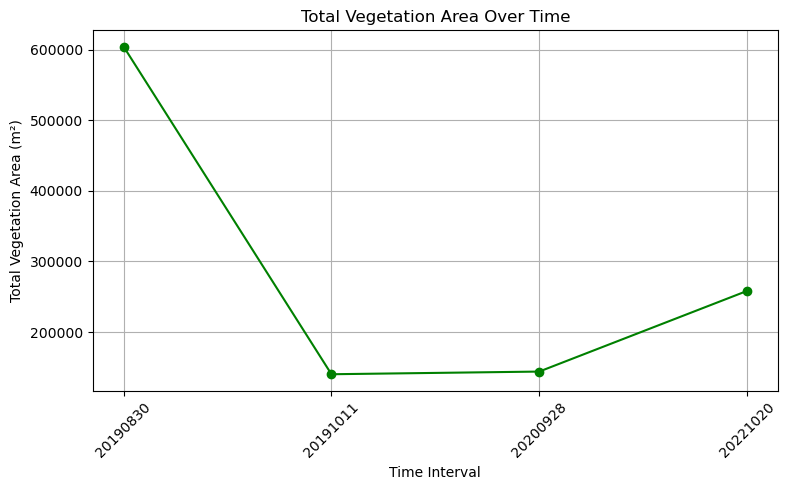

In [27]:
# Calculate total vegetation area (dense + sparse) for each time period
dorian['20190830_total_veg_area'] = dorian['20190830_dense_veg_area'] + dorian['20190830_sparse_veg_area']
dorian['20191011_total_veg_area'] = dorian['20191011_dense_veg_area'] + dorian['20191011_sparse_veg_area']
dorian['20200928_total_veg_area'] = dorian['20200928_dense_veg_area'] + dorian['20200928_sparse_veg_area']
dorian['20221020_total_veg_area'] = dorian['20221020_dense_veg_area'] + dorian['20221020_sparse_veg_area']

# Sum the vegetation areas across all rows for each time interval
veg_area_sums = {
    '20190830': dorian['20190830_total_veg_area'].sum(),
    '20191011': dorian['20191011_total_veg_area'].sum(),
    '20200928': dorian['20200928_total_veg_area'].sum(),
    '20221020': dorian['20221020_total_veg_area'].sum()
}

# Create a DataFrame for easy plotting
veg_area_df_dorian = pd.DataFrame(list(veg_area_sums.items()), columns=['Time Interval', 'Total Veg Area'])

# Save the veg_area_df as a CSV file
veg_area_df_.to_csv('Dorian_vegetation_area_sums.csv', index=False)

# Verify that the file was saved correctly by printing a success message
print("CSV file 'Dorian_vegetation_area_sums.csv' has been saved successfully.")

# Plotting the total vegetation area over the four time intervals
plt.figure(figsize=(8, 5))
plt.plot(veg_area_df['Time Interval'], veg_area_df['Total Veg Area'], marker='o', color='green')
plt.title('Total Vegetation Area Over Time')
plt.xlabel('Time Interval')
plt.ylabel('Total Vegetation Area (m²)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

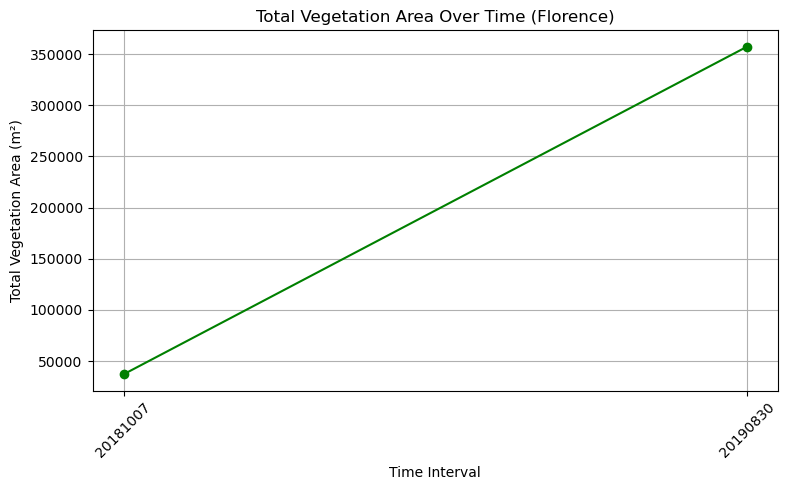

CSV file 'florence_vegetation_area_sums.csv' has been saved successfully.


In [29]:
# 1. Load the harvey dataset and skip the necessary rows if needed
# Adjust the path to your CSV file
harvey = pd.read_csv('Supplemental_Table_harvey.csv', skiprows=3, header=None)
harvey = harvey.drop(harvey.columns[[6, 11]], axis=1)
# 2. Rename the columns (only 201703 and 20190830 time intervals)
col_names_harvey = ['num', 'area_m2', '201703_dense_veg', '201703_sparse_veg', '201703_sand', '201703_water',
                      '20190830_dense_veg', '20190830_sparse_veg', '20190830_sand', '20190830_water']
harvey.columns = col_names_harvey

# 3. Calculate fractional areas for 201703 and 20190830
# Sum columns to get the total for each time interval
harvey['201703_total'] = harvey[['201703_dense_veg', '201703_sparse_veg', '201703_sand', '201703_water']].sum(axis=1)
harvey['20190830_total'] = harvey[['20190830_dense_veg', '20190830_sparse_veg', '20190830_sand', '20190830_water']].sum(axis=1)

# Calculate fractions
harvey['201703_dense_veg_frac'] = harvey['201703_dense_veg'] / harvey['201703_total']
harvey['201703_sparse_veg_frac'] = harvey['201703_sparse_veg'] / harvey['201703_total']
harvey['20190830_dense_veg_frac'] = harvey['20190830_dense_veg'] / harvey['20190830_total']
harvey['20190830_sparse_veg_frac'] = harvey['20190830_sparse_veg'] / harvey['20190830_total']

# 4. Multiply area_m2 by the fractional columns to calculate actual areas
# For the 201703 time interval
harvey['201703_dense_veg_area'] = harvey['area_m2'] * harvey['201703_dense_veg_frac']
harvey['201703_sparse_veg_area'] = harvey['area_m2'] * harvey['201703_sparse_veg_frac']

# For the 20190830 time interval
harvey['20190830_dense_veg_area'] = harvey['area_m2'] * harvey['20190830_dense_veg_frac']
harvey['20190830_sparse_veg_area'] = harvey['area_m2'] * harvey['20190830_sparse_veg_frac']

# 5. Sum vegetation areas for each time interval
harvey['201703_total_veg_area'] = harvey['201703_dense_veg_area'] + harvey['201703_sparse_veg_area']
harvey['20190830_total_veg_area'] = harvey['20190830_dense_veg_area'] + harvey['20190830_sparse_veg_area']

# Sum across all rows for each time interval
veg_area_sums_harvey = {
    '201703': harvey['201703_total_veg_area'].sum(),
    '20190830': harvey['20190830_total_veg_area'].sum()
}

# 6. Create a DataFrame for easy plotting
veg_area_df_harvey = pd.DataFrame(list(veg_area_sums_harvey.items()), columns=['Time Interval', 'Total Veg Area'])

# 7. Plot the total vegetation area over the two time intervals
plt.figure(figsize=(8, 5))
plt.plot(veg_area_df_harvey['Time Interval'], veg_area_df_harvey['Total Veg Area'], marker='o', color='green')
plt.title('Total Vegetation Area Over Time (harvey)')
plt.xlabel('Time Interval')
plt.ylabel('Total Vegetation Area (m²)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 8. Save the veg_area_df_harvey as a CSV file
veg_area_df_harvey.to_csv('harvey_vegetation_area_sums.csv', index=False)

# Verify that the file was saved correctly by printing a success message
print("CSV file 'harvey_vegetation_area_sums.csv' has been saved successfully.")

In [33]:
harvey = pd.read_csv('Supplemental_Table_Harvey.csv', skiprows=2 )
col_names_harvey = ['num', 'area_m2', '201703_veg', '201703_sand', '201703_water','201708_veg', '201708_sand', '201708_water',
                                      '202001_veg', '202001_sand', '202001_water','202203_veg', '202203_sand', '202203_water',
                                      '202306_veg', '202306_sand', '202306_water' ]
                      

,Overwash ID,Area_m2,Unnamed: 2,vegetation,sand,water,Unnamed: 6,vegetation.1,sand.1,water.1,...,sand.2,water.2,Unnamed: 14,vegetation.3,sand.3,water.3,Unnamed: 18,vegetation.4,sand.4,water.4
0,1,28884.40,NaN,29979,9432,0,NaN,70,6570,30475,...,15806,19732,NaN,693,34016,2395,NaN,2362,33056,1697
1,2,9367.46,NaN,8721,3573,0,NaN,0,2368,9673,...,7569,3627,NaN,355,11664,15,NaN,561,11480,0
2,3,85327.80,NaN,75123,27342,0,NaN,2134,29224,78245,...,55144,42395,NaN,2319,101185,6100,NaN,4983,101191,3428
3,4,64818.70,NaN,63603,15633,0,NaN,5514,28855,48899,...,36078,34877,NaN,4291,68213,10778,NaN,7139,71699,4433
4,5,176402.00,NaN,154296,53289,0,NaN,11493,79532,135611,...,74957,136959,NaN,5421,166776,54435,NaN,8099,186799,31737
5,6,25958.50,NaN,19575,11340,0,NaN,1230,19013,13113,...,15679,12536,NaN,4212,28433,719,NaN,3278,30031,45
6,7,64147.40,NaN,51174,18423,0,NaN,333,45173,36930,...,23755,55335,NaN,3063,65522,13860,NaN,6427,68773,7240
7,8,46494.70,NaN,45864,10215,0,NaN,1373,31479,26888,...,28593,28671,NaN,2426,46996,10322,NaN,4222,50853,4663
8,9,11638.20,NaN,9414,3222,0,NaN,0,4762,10216,...,9055,5450,NaN,363,12241,2353,NaN,769,13161,1048


In [36]:
harvey = pd.read_csv('Supplemental_Table_Harvey.csv', skiprows=2, header=None)
harvey = harvey.drop(harvey.columns[[2, 6, 10, 14, 18]], axis=1)
col_names_harvey = ['num', 'area_m2', '201703_veg', '201703_sand', '201703_water','201708_veg', '201708_sand', '201708_water',
                                      '202001_veg', '202001_sand', '202001_water','202203_veg', '202203_sand', '202203_water',
                                      '202306_veg', '202306_sand', '202306_water' ]
harvey.columns = col_names_harvey
harvey

,num,area_m2,201703_veg,201703_sand,201703_water,201708_veg,201708_sand,201708_water,202001_veg,202001_sand,202001_water,202203_veg,202203_sand,202203_water,202306_veg,202306_sand,202306_water
0,Overwash ID,Area_m2,vegetation,sand,water,vegetation,sand,water,vegetation,sand,water,vegetation,sand,water,vegetation,sand,water
1,1,28884.4,29979,9432,0,70,6570,30475,1565,15806,19732,693,34016,2395,2362,33056,1697
2,2,9367.46,8721,3573,0,0,2368,9673,850,7569,3627,355,11664,15,561,11480,0
3,3,85327.8,75123,27342,0,2134,29224,78245,12070,55144,42395,2319,101185,6100,4983,101191,3428
4,4,64818.7,63603,15633,0,5514,28855,48899,12312,36078,34877,4291,68213,10778,7139,71699,4433
5,5,176402,154296,53289,0,11493,79532,135611,14731,74957,136959,5421,166776,54435,8099,186799,31737
6,6,25958.5,19575,11340,0,1230,19013,13113,5144,15679,12536,4212,28433,719,3278,30031,45
7,7,64147.4,51174,18423,0,333,45173,36930,3330,23755,55335,3063,65522,13860,6427,68773,7240
8,8,46494.7,45864,10215,0,1373,31479,26888,2485,28593,28671,2426,46996,10322,4222,50853,4663
9,9,11638.2,9414,3222,0,0,4762,10216,456,9055,5450,363,12241,2353,769,13161,1048


In [ ]:
# 3. Calculate fractional areas for 201703, 201708
# Sum columns to get the total for each time interval
harvey['201703_total'] = harvey[['201703_veg', '201703_sand', '201703_water']].sum(axis=1)

# Calculate fractions
harvey['201703_veg_frac'] = harvey['201703_veg'] / harvey['201703_total']

# 4. Multiply area_m2 by the fractional columns to calculate actual areas
# For the 201703 time interval
harvey['201703_veg_area'] = harvey['area_m2'] * harvey['201703_veg_frac']